In [1]:
!pip3 install --quiet torch torchvision torchaudio matplotlib tensorboardX opencv-python lpips tqdm fvcore

DEPRECATION: Loading egg at /home/user/.local/lib/python3.11/site-packages/nms_1d_cpu-0.0.0-py3.11-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [2]:
!python --version

Python 3.11.11


In [3]:
!pwd

/home/user/ashutosh


In [4]:
import torch
import random
import numpy as np
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from PIL import Image
from PIL import ImageFile
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from torchvision.utils import make_grid, save_image
from tensorboardX import SummaryWriter
import torch.optim as optim
import torchvision
import lpips
from tqdm import tqdm

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

print('Using device: {}'.format(device))

Using device: cuda:0


In [5]:
# Fixed random number seed
SEED = 99

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [6]:
def make_directory(dir_path: str) -> None:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

In [7]:
class conv(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, dilation_rate=1, padding=0, stride=1):
        super(conv, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=kernel_size, stride=stride,
                              padding=padding, bias=True, dilation=dilation_rate)

    def forward(self, x_input):
        out = self.conv(x_input)
        return out


class conv_relu(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, dilation_rate=1, padding=0, stride=1):
        super(conv_relu, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=kernel_size, stride=stride,
                      padding=padding, bias=True, dilation=dilation_rate),
            nn.ReLU(inplace=True)
        )

    def forward(self, x_input):
        out = self.conv(x_input)
        return out

In [8]:
class RRDB(nn.Module):
    def __init__(self, in_channel, d_list, inter_num):
        super(RRDB, self).__init__()
        self.d_list = d_list
        self.conv_layers = nn.ModuleList()
        c = in_channel
        for i in range(len(d_list)):
            dense_conv = conv_relu(in_channel=c, out_channel=inter_num, kernel_size=3, dilation_rate=d_list[i],
                                   padding=d_list[i])
            self.conv_layers.append(dense_conv)
            c = c + inter_num
        self.conv_post = conv(in_channel=c, out_channel=in_channel, kernel_size=1)

    def forward(self, x):
        t = x
        for conv_layer in self.conv_layers:
            _t = conv_layer(t)
            t = torch.cat([_t, t], dim=1)

        t = self.conv_post(t)
        return t + x

In [9]:
class Attention(nn.Module):

    def __init__(self, dim, n_heads = 1, qkv_bias = True, attn_p = 0., proj_p = 0.):
        super().__init__()
        self.conv1 = nn.Conv2d(dim // 3, dim // 3, 1, 1, 0)
        self.conv2 = nn.Conv2d(dim // 3, dim // 3, 1, 1, 0)
        self.conv3 = nn.Conv2d(dim // 3, dim // 3, 1, 1, 0)
        # self.excitation = nn.Conv2d(in_chnls // ratio, in_chnls, 1, 1, 0)

        self.trans_conv1 = nn.ConvTranspose2d(dim // 3, dim // 3, 3, 1, 1)
        self.trans_conv2 = nn.ConvTranspose2d(dim // 3, dim // 3, 3, 1, 1)
        self.trans_conv3 = nn.ConvTranspose2d(dim // 3, dim // 3, 3, 1, 1)

        
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias = qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)


    def forward(self, x):
        # print('x.shape', x.shape)
        # batch_size, channels, n_tokens, dim = x.shape
    
        # if dim != self.dim:
        #   raise ValueError
    
        q = self.trans_conv1(self.conv1(x))
        k = self.trans_conv2(self.conv2(x))
        v = self.trans_conv3(self.conv3(x))


        
        # print('q.shape', q.shape)
        # print('k.shape', k.shape)
        # print('v.shape', v.shape)
        
        
        q = q.reshape(q.shape[0], q.shape[1], -1)
        k = k.reshape(k.shape[0], k.shape[1], -1).transpose(1, 2)
        v = v.reshape(v.shape[0], v.shape[1], -1)

        # print('q.shape', q.shape)
        # print('k.shape', k.shape)
        # print('v.shape', v.shape)
        
        # qkv = qkv.permute(
        #   2, 0, 3, 1, 4
        # ) # (3, n_samples, n_heads, n_patches + 1, head_dim)
    
        # q, k, v = qkv[0], qkv[1], qkv[2]
    
        dp = (
          q @ k
        ) * self.scale # (n_samples, n_heads, n_patches + 1, n_patches + 1)
    
        attn = dp.softmax(dim = -1) # (n_samples, n_heads, n_patches + 1, n_patches + 1)

        # print('attn.shape', attn.shape)
        
        weighted_avg = attn @ v # (n_samples, n_heads, n_patches + 1, head_dim)

        weighted_avg = weighted_avg.reshape(x.shape[0], x.shape[1], x.shape[2], x.shape[3])
    
        return weighted_avg


In [10]:
class CSAF(nn.Module):
    def __init__(self, in_chnls, ratio=4):
        super(CSAF, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d((1, 1))

        self.attn = Attention(3 * in_chnls)

    def forward(self, x0, x2, x4):
        
        out = torch.cat([x0, x2, x4], dim=1)

        out = self.attn(out)
        
        w0, w2, w4 = torch.chunk(out, 3, dim=1)

        # print('w0.shape', w0.shape)
        # print('w2.shape', w2.shape)
        # print('w4.shape', w4.shape)

        # print('x0.shape', x0.shape)


        x = x0 * w0 + x2 * w2 + x4 * w4

        return x

In [11]:
class DB(nn.Module):
    def __init__(self, in_channel, d_list, inter_num):
        super(DB, self).__init__()
        self.d_list = d_list
        self.conv_layers = nn.ModuleList()
        c = in_channel
        for i in range(len(d_list)):
            dense_conv = conv_relu(in_channel=c, out_channel=inter_num, kernel_size=3, dilation_rate=d_list[i],
                                   padding=d_list[i])
            self.conv_layers.append(dense_conv)
            c = c + inter_num
        self.conv_post = conv(in_channel=c, out_channel=in_channel, kernel_size=1)

    def forward(self, x):
        t = x
        for conv_layer in self.conv_layers:
            _t = conv_layer(t)
            t = torch.cat([_t, t], dim=1)
        t = self.conv_post(t)
        return t

In [12]:
class SAM(nn.Module):
    def __init__(self, in_channel, d_list, inter_num):
        super(SAM, self).__init__()
        self.basic_block = DB(in_channel=in_channel, d_list=d_list, inter_num=inter_num)
        self.basic_block_2 = DB(in_channel=in_channel, d_list=d_list, inter_num=inter_num)
        self.basic_block_4 = DB(in_channel=in_channel, d_list=d_list, inter_num=inter_num)
        self.fusion = CSAF(3 * in_channel)

    def forward(self, x):
        x_0 = x
        x_2 = F.interpolate(x, scale_factor=0.5, mode='bilinear')
        x_4 = F.interpolate(x, scale_factor=0.25, mode='bilinear')
        y_0 = self.basic_block(x_0)
        y_2 = self.basic_block_2(x_2)
        y_4 = self.basic_block_4(x_4)

        y_2 = F.interpolate(y_2, scale_factor=2, mode='bilinear')
        y_4 = F.interpolate(y_4, scale_factor=4, mode='bilinear')

        y = self.fusion(y_0, y_2, y_4)
        y = x + y
        return y

In [13]:
class MFEN(nn.Module):

    def __init__(
        self,
        en_feature_num,
        en_inter_num,
        de_feature_num,
        de_inter_num
    ):
        super(MFEN, self).__init__()

        # Encoder
        self.conv_first = nn.Sequential(
            nn.Conv2d(12, en_feature_num, kernel_size = 5, stride = 1, padding = 2, bias = True),
            nn.ReLU(inplace = True)
        )

        self.rdb1 = RRDB(in_channel = en_feature_num, d_list=(1, 2, 1), inter_num = en_inter_num)
        self.sam_block1 = SAM(in_channel = en_feature_num, d_list=(1, 2, 3, 2, 1), inter_num = en_inter_num)

        self.down1 = nn.Sequential(
            nn.Conv2d(en_feature_num, 2 * en_feature_num, kernel_size = 3, stride =2, padding = 1, bias = True),
            nn.ReLU(inplace = True)
        )

        self.rdb2 = RRDB(in_channel = 2 * en_feature_num, d_list = (1, 2, 1), inter_num = en_inter_num)
        self.sam_block2 = SAM(in_channel = 2 * en_feature_num, d_list = (1, 2, 3, 2, 1), inter_num = en_inter_num)

        self.down2 = nn.Sequential(
            nn.Conv2d(2 * en_feature_num, 4 * en_feature_num, kernel_size = 3, stride = 2, padding = 1, bias = True),
            nn.ReLU(inplace = True)
        )

        self.rdb3 = RRDB(in_channel = 4 * en_feature_num, d_list=(1, 2, 1), inter_num = en_inter_num)
        self.sam_block3 = SAM(in_channel = 4 * en_feature_num, d_list = (1, 2, 3, 2, 1), inter_num = en_inter_num)


        # Decoder
        # Level 3
        self.preconv_3 = conv_relu(4 * en_feature_num, de_feature_num, 3, padding=1)
        self.d_rdb3 = RRDB(de_feature_num, (1, 2, 1), de_inter_num)
        self.d_sam_block3 = SAM(in_channel = de_feature_num, d_list = (1, 2, 3, 2, 1), inter_num = de_inter_num)

        self.conv_3 = conv(in_channel=de_feature_num, out_channel=12, kernel_size=3, padding=1)

        # Level 2
        self.preconv_2 = conv_relu(2 * en_feature_num + de_feature_num, de_feature_num, 3, padding=1)
        self.d_rdb2 = RRDB(de_feature_num, (1, 2, 1), de_inter_num)
        self.d_sam_block2 = SAM(in_channel = de_feature_num, d_list = (1, 2, 3, 2, 1), inter_num = de_inter_num)

        self.conv_2 = conv(in_channel=de_feature_num, out_channel=12, kernel_size=3, padding=1)

        # Level 3
        self.preconv_1 = conv_relu(en_feature_num + de_feature_num, de_feature_num, 3, padding=1)
        self.d_rdb1 = RRDB(de_feature_num, (1, 2, 1), de_inter_num)
        self.d_sam_block1 = SAM(in_channel = de_feature_num, d_list = (1, 2, 3, 2, 1), inter_num = de_inter_num)

        self.conv_1 = conv(in_channel = de_feature_num, out_channel=12, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.pixel_unshuffle(x, 2)
        x = self.conv_first(x)

        x_1 = self.rdb1(x)
        x_1 = self.sam_block1(x_1)
        down_1 = self.down1(x_1)

        x_2 = self.rdb2(down_1)
        x_2 = self.sam_block2(x_2)
        down_2 = self.down2(x_2)

        x_3 = self.rdb3(down_2)
        x_3 = self.sam_block3(x_3)

        y_3 = self.preconv_3(x_3)
        y_3 = self.d_rdb3(y_3)
        y_3 = self.d_sam_block3(y_3)

        out_3 = self.conv_3(y_3)
        out_3 = F.pixel_shuffle(out_3, 2)


        y_3 = F.interpolate(y_3, scale_factor = 2, mode = 'bilinear')

        y_2 = torch.cat([x_2, y_3], dim = 1)
        y_2 = self.preconv_2(y_2)

        y_2 = self.d_rdb2(y_2)
        y_2 = self.d_sam_block2(y_2)

        out_2 = self.conv_2(y_2)
        out_2 = F.pixel_shuffle(out_2, 2)

        y_2 = F.interpolate(y_2, scale_factor = 2, mode = 'bilinear')


        y_1 = torch.cat([x_1, y_2], dim = 1)
        y_1 = self.preconv_1(y_1)

        y_1 = self.d_rdb1(y_1)
        y_1 = self.d_sam_block1(y_1)

        out_1 = self.conv_1(y_1)
        out_1 = F.pixel_shuffle(out_1, 2)

        # y_1 = F.interpolate(y_1, scale_factor = 2, mode = 'bilinear')

        return out_1, out_2, out_3


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, 0.02)
                if m.bias is not None:
                    m.bias.data.normal_(0.0, 0.02)
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0.0, 0.02)

In [14]:
EXP_NAME = "mfen"

BATCH_SIZE = 2
NUM_WORKERS = 8

en_feature_num = 48
en_inter_num = 32
de_feature_num = 64
de_inter_num = 32

In [15]:
model = MFEN(
    en_feature_num = en_feature_num,
    en_inter_num = en_inter_num,
    de_feature_num = de_feature_num,
    de_inter_num = de_inter_num
).to(device)

In [16]:
total_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print("Total parameters:", total_params)

Total parameters: 41692308


In [17]:
test_img = torch.randn((4, 3, 256, 256))
test_img = test_img.to(device)
print(test_img.shape)

torch.Size([4, 3, 256, 256])


In [18]:
import time 

begin = time.time()

out1, out2, out3 = model(test_img)

end = time.time()

print(f"Total inference time: { end - begin }")

print(out1.shape, out2.shape, out3.shape)

Total inference time: 1.2042839527130127
torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 128, 128]) torch.Size([4, 3, 64, 64])


In [19]:
from fvcore.nn import FlopCountAnalysis

flops = FlopCountAnalysis(model, test_img)
flops.total()

Unsupported operator aten::pixel_unshuffle encountered 1 time(s)
Unsupported operator aten::add encountered 24 time(s)
Unsupported operator aten::mul encountered 24 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::pixel_shuffle encountered 3 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
d_sam_block1.fusion.attn.attn_drop, d_sam_block1.fusion.attn.proj, d_sam_block1.fusion.attn.proj_drop, d_sam_block1.fusion.attn.qkv, d_sam_block1.fusion.squeeze, d_sam_block2.fusion.attn.attn_drop, d_sam_block2.fusion.attn.proj, d_sam_block2.fusion.attn.proj_drop, d_sam_block2.fusion.attn.qkv, d_sam_block2.fusion.squeeze, d_sam_block3.fusion.attn.attn_drop, d_sam_block3.fusion.attn.

302257405952

In [20]:
class UIEBDataset(data.Dataset):

  def __init__(
    self,
    train_dataset,
    crop_size,
    test_dataset,
    mode = 'train'
  ):
    self.raw_path = train_dataset + 'raw-890/'
    self.gt_path = train_dataset + 'reference-890/'

    self.crop_size = crop_size
    train_list_path = train_dataset + 'uie_train_list.txt'
    test_list_path = test_dataset + 'uie_test_list.txt'

    self.mode = mode

    if self.mode == 'train':
      f = open(train_list_path)
    elif self.mode == 'test' or self.mode == 'valid':
      f = open(test_list_path)

    self.filenames = f.readlines()


  def __getitem__(self, item):

    raw_item_path = os.path.join(
      self.raw_path, self.filenames[item].rstrip())
    gt_item_path = os.path.join(
      self.gt_path, self.filenames[item].rstrip())

    raw_img = Image.open(raw_item_path)
    gt_img = Image.open(gt_item_path)

    transform = transforms.Compose([
      transforms.Resize((self.crop_size, self.crop_size)),
      transforms.ToTensor()
    ])

    return {
      'in_img': transform(raw_img),
      'label': transform(gt_img),
      'filename': self.filenames[item].rstrip()
    }

  def __len__(self):
    return len(self.filenames)


In [21]:
class UIEBUnpairedDataset(data.Dataset):

  def __init__(
    self,
    train_dataset,
    crop_size
  ):
    self.raw_path = train_dataset + 'challenging-60/'

    self.crop_size = crop_size
    non_reference_list_path = train_dataset + 'uie_non_reference.txt'

    f = open(non_reference_list_path)
    self.filenames = f.readlines()


  def __getitem__(self, item):

    raw_item_path = os.path.join(
      self.raw_path, self.filenames[item].rstrip())

    raw_img = Image.open(raw_item_path)

    transform = transforms.Compose([
      transforms.Resize((self.crop_size, self.crop_size)),
      transforms.ToTensor()
    ])

    transformed_img = transform(raw_img)

    return {
      'in_img': transformed_img,
      'filename': self.filenames[item].rstrip()
    }

  def __len__(self):
    return len(self.filenames)


Total training image pairs: 800
Total validation image pairs: 90
Total test unpaired images: 60


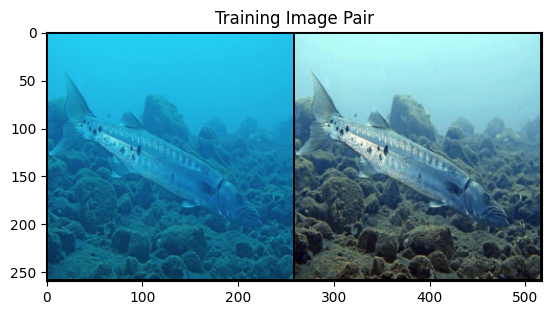

In [22]:
train_dataset = UIEBDataset(
    train_dataset = './uieb_data/',
    crop_size = 256,
    test_dataset = './uieb_data/'
)

val_dataset = UIEBDataset(
    train_dataset = './uieb_data/',
    crop_size = 256,
    test_dataset = './uieb_data/',
    mode = 'valid'
)

test_dataset = UIEBUnpairedDataset(
    train_dataset = './uieb_data/',
    crop_size = 256
)

print("Total training image pairs:", len(train_dataset))
print("Total validation image pairs:", len(val_dataset))
print("Total test unpaired images:", len(test_dataset))

sample_train_image = next(iter(train_dataset))

grid = torch.vstack((sample_train_image['in_img'].unsqueeze(0), sample_train_image['label'].unsqueeze(0)))

plt.title("Training Image Pair")
plt.imshow(make_grid(grid).permute(1, 2, 0))

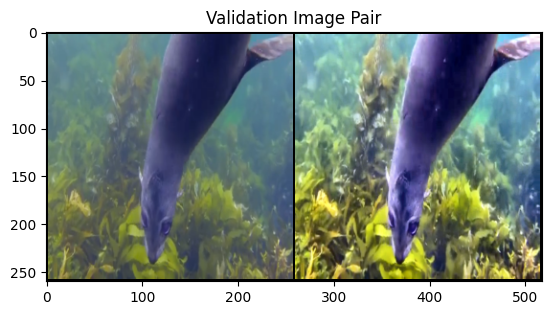

In [23]:
sample_val_image = next(iter(val_dataset))

grid = torch.vstack((sample_val_image['in_img'].unsqueeze(0), sample_val_image['label'].unsqueeze(0)))

plt.title("Validation Image Pair")
plt.imshow(make_grid(grid).permute(1, 2, 0))

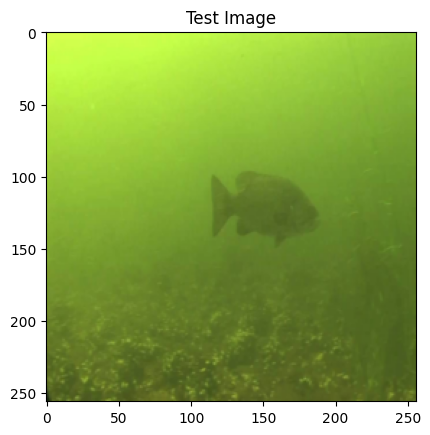

In [24]:
sample_test_image = next(iter(test_dataset))

plt.title("Test Image")
plt.imshow(sample_test_image['in_img'].permute(1, 2, 0))

In [25]:
train_dataloader = data.DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle=True,
    num_workers = NUM_WORKERS,
    drop_last=True
)

val_dataloader = data.DataLoader(
    val_dataset,
    batch_size = BATCH_SIZE,
    shuffle=True,
    num_workers = NUM_WORKERS,
    drop_last=True
)

test_dataloader = data.DataLoader(
    test_dataset,
    batch_size = BATCH_SIZE,
    shuffle=True,
    num_workers = NUM_WORKERS,
    drop_last=True
)

In [26]:
# Create the folder where the model weights are saved
samples_dir = os.path.join("samples", EXP_NAME)
results_dir = os.path.join("results", EXP_NAME)
make_directory(samples_dir)
make_directory(results_dir)

# create model training log
writer = SummaryWriter(os.path.join("samples", "logs", EXP_NAME))

In [27]:
from LAB import lab_Loss
from LCH import lch_Loss

class MultiVGGPerceptualLoss(torch.nn.Module):
    def __init__(self, lam = 1, lam_p = 1, lam_lpips = 1):
        super(MultiVGGPerceptualLoss, self).__init__()

        self.loss_fn = VGGPerceptualLoss()
        self.lpips_fn = lpips.LPIPS(net = 'vgg')

        self.lam = lam
        self.lam = 1
        self.lam_p = lam_p
        self.lam_p = 1
        self.lam_lpips = lam_lpips
        self.L_lab = lab_Loss()
        self.L_lch = lch_Loss()
        self.lam_lab = 0.000001
        self.lam_lch = 0.01
        # self.lam_rgb = 0.1

    def forward(self, out1, out2, out3, gt1, feature_layers=[2]):
        gt2 = F.interpolate(gt1, scale_factor=0.5, mode='bilinear', align_corners=False)
        gt3 = F.interpolate(gt1, scale_factor=0.25, mode='bilinear', align_corners=False)



        loss1 = self.lam_p * self.loss_fn(out1, gt1, feature_layers=feature_layers) + self.lam * F.l1_loss(out1, gt1) + \
                self.lam_lab * self.L_lab(out1, gt1) + self.lam_lch * self.L_lch(out1, gt1)
        # return loss1
        loss2 = self.lam_p * self.loss_fn(out2, gt2, feature_layers=feature_layers) + self.lam * F.l1_loss(out2, gt2) + \
                self.lam_lab * self.L_lab(out2, gt2) + self.lam_lch * self.L_lch(out2, gt2)
        
        loss3 = self.lam_p * self.loss_fn(out3, gt3, feature_layers=feature_layers) + self.lam * F.l1_loss(out3, gt3) + \
                self.lam_lab * self.L_lab(out3, gt3) + self.lam_lch * self.L_lch(out3, gt3)

        return loss1 + loss2 + loss3

class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained = True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained = True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained = True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained = True).features[16:23].eval())
        for bl in blocks:
            for p in bl:
                p.requires_grad = False
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.mean = torch.nn.Parameter(torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1))
        self.std = torch.nn.Parameter(torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1))
        self.resize = resize

    def forward(self, input, target, feature_layers=[0, 1, 2, 3], style_layers=[]):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input - self.mean) / self.std
        target = (target - self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners = False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners = False)
        loss = 0.0
        x = input
        y = target
        for i, block in enumerate(self.blocks):
            x = block(x)
            y = block(y)
            if i in feature_layers:
                loss += torch.nn.functional.l1_loss(x, y)
            if i in style_layers:
                act_x = x.reshape(x.shape[0], x.shape[1], -1)
                act_y = y.reshape(y.shape[0], y.shape[1], -1)
                gram_x = act_x @ act_x.permute(0, 2, 1)
                gram_y = act_y @ act_y.permute(0, 2, 1)
                loss += torch.nn.functional.l1_loss(gram_x, gram_y)
        return loss

In [28]:
def train(epoch, train_dataloader, optimizer, model, loss_fn, writer, num_batches):
    tbar = tqdm(train_dataloader)
    total_loss = 0.
    total = 0
    model.train()

    for batch_index, batch in enumerate(tbar):
        # print(batch)
        gt = batch['label'].to(device)
        in_img = batch['in_img'].to(device)

        optimizer.zero_grad()

        out1, out2, out3 = model(in_img)

        loss = loss_fn(out1, out2, out3, gt)

        loss.backward()
        optimizer.step()

        total += 1
        total_loss += loss.item()
        avg_loss = total_loss / total

        # Output training log information once
        if batch_index % 10 == 0:
            # write training log
            iters = batch_index + epoch * num_batches
            writer.add_scalar("Train/Loss", avg_loss, iters)

        tbar.set_description("[Epoch {}] [Avg loss : {:.4f}]".format(epoch + 1, avg_loss))
        tbar.update()

In [29]:
from image_quality_assessment import PSNR, SSIM

def build_iqa_model(
        crop_border,
        only_test_y_channel,
        device
):
    psnr_model = PSNR(crop_border=crop_border, only_test_y_channel=only_test_y_channel, data_range=1.0)
    ssim_model = SSIM(crop_border=crop_border, only_test_y_channel=only_test_y_channel, data_range=255.0)

    psnr_model = psnr_model.to(device)
    ssim_model = ssim_model.to(device)

    return psnr_model, ssim_model


psnr_model, ssim_model = build_iqa_model(
    4,
    True,
    device,
)

In [30]:
def validate(epoch, model, val_dataloader, psnr_model, ssim_model):
    model.eval()

    with torch.no_grad():
        total_psnr = 0.
        total_ssim = 0.
        count = 0.
        epoch_result_dir = os.path.join(results_dir, "epoch_" + str(epoch + 1))

        make_directory(epoch_result_dir)

        for batch_index, batch in enumerate(val_dataloader):
            gt = batch['label'].to(device)
            in_img = batch['in_img'].to(device)

            restored, out_2, out_3 = model(in_img)

            psnr = psnr_model(restored, gt)
            ssim = ssim_model(restored, gt)

            total_psnr += psnr.mean().item()
            total_ssim += ssim.mean().item()

            count += 1

            in_img = in_img.detach().cpu()
            restored_img = restored.detach().cpu()
            gt_img = gt.detach().cpu()
            for i in range(len(batch['filename'])):
                grid = torch.vstack((in_img[i].unsqueeze(0), restored_img[i].unsqueeze(0), gt_img[i].unsqueeze(0)))
                # save_image(grid, os.path.join(epoch_result_dir, batch['filename'][i]))
                save_image(restored_img[i], os.path.join(epoch_result_dir, batch['filename'][i]))

        avg_psnr = total_psnr / count
        avg_ssim = total_ssim / count

        return avg_psnr, avg_ssim

In [ ]:
num_batches = len(train_dataloader)
start_epoch = 0
total_epochs = 100

best_psnr = 0.
best_ssim = 0.

load_epoch = None
optimizer = optim.Adam([{'params': model.parameters(), 'initial_lr': 0.000002}], betas=(0.9, 0.999))

loss_fn = MultiVGGPerceptualLoss().to(device)

if load_epoch:
    start_epoch = load_epoch
    load_path = os.path.join(samples_dir, "epoch_{}.pth".format(load_epoch))
    checkpoint = torch.load(load_path)

    start_epoch = checkpoint["epoch"]
    best_psnr = max(best_psnr, checkpoint["psnr"])
    best_ssim = max(best_ssim, checkpoint["ssim"])
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])


    print("Loaded checkpoint with epoch {}, PSNR {:.4f} and SSIM {:.4f}".format(
        start_epoch, checkpoint["psnr"], checkpoint["ssim"]))

# psnr, ssim = validate(100, model, val_dataloader, psnr_model, ssim_model)
for epoch in range(start_epoch, total_epochs):
    # Train epoch
    train(epoch, train_dataloader, optimizer, model, loss_fn, writer, num_batches)

    # Validate epoch
    psnr, ssim = validate(epoch, model, val_dataloader, psnr_model, ssim_model)

    # Write the evaluation indicators of each round of Epoch to the log
    writer.add_scalar(f"Validation/PSNR", psnr, epoch + 1)
    writer.add_scalar(f"Validation/SSIM", ssim, epoch + 1)

    best_psnr = max(psnr, best_psnr)
    best_ssim = max(ssim, best_ssim)

    print("[Epoch {}] [Avg PSNR: {:.4f}] [Avg SSIM: {:.4f}]".format(epoch + 1, psnr, ssim))

    save_path = os.path.join(samples_dir, "epoch_{}.pth".format(epoch  + 1))

    torch.save({
        "epoch": epoch + 1,
        "psnr": psnr,
        "ssim": ssim,
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict()
    }, save_path)

print("Best PSNR: {} and SSIM : {}".format(best_psnr, best_ssim))
